<a href="https://colab.research.google.com/github/qoyyimil/pba/blob/main/notebooks/3_EDA_BoW_Regex_Analysis_Moovit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA, Bag of Words, & Regex Analysis for Moovit Reviews
Notebook ini berisi analisis lanjutan dari data review aplikasi Moovit yang sudah dibersihkan.

In [1]:
# --- Instalasi Library ---
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install wordcloud

# --- Import Library ---
import pandas as pd
import numpy as np
import re

# -- Library untuk Visualisasi --
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# -- Library untuk BoW --
from sklearn.feature_extraction.text import CountVectorizer

# --- Konfigurasi Tampilan ---
pd.set_option("display.max_colwidth", 200)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
# Load dataset yang sudah bersih
try:
    df = pd.read_csv('moovit_reviews_cleaned.csv')
except FileNotFoundError:
    print("File 'moovit_reviews_cleaned.csv' tidak ditemukan. Pastikan file tersebut ada di direktori yang sama.")
else:
    # Mengubah kolom 'at' menjadi tipe data datetime untuk analisis waktu
    df['at'] = pd.to_datetime(df['at'])

    # Menangani nilai NaN di final_content jika ada
    df.dropna(subset=['final_content'], inplace=True)

    print("Dataset bersih berhasil dimuat.")
    print(f"Jumlah baris: {len(df)}.")
    df.head()

Dataset bersih berhasil dimuat.
Jumlah baris: 2198.


## Tugas 1: Analisa EDA (Exploratory Data Analysis)
Di bagian ini, kita akan melakukan eksplorasi data untuk mendapatkan wawasan dari ulasan pengguna.
1.  Distribusi Skor (Rating)
2.  Analisis Jumlah Review per Tahun (Tugas Kaggle)
3.  Analisis Panjang Ulasan
4.  Visualisasi Word Cloud

/tmp/ipython-input-1659328240.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='score', palette='viridis', order=[1, 2, 3, 4, 5])


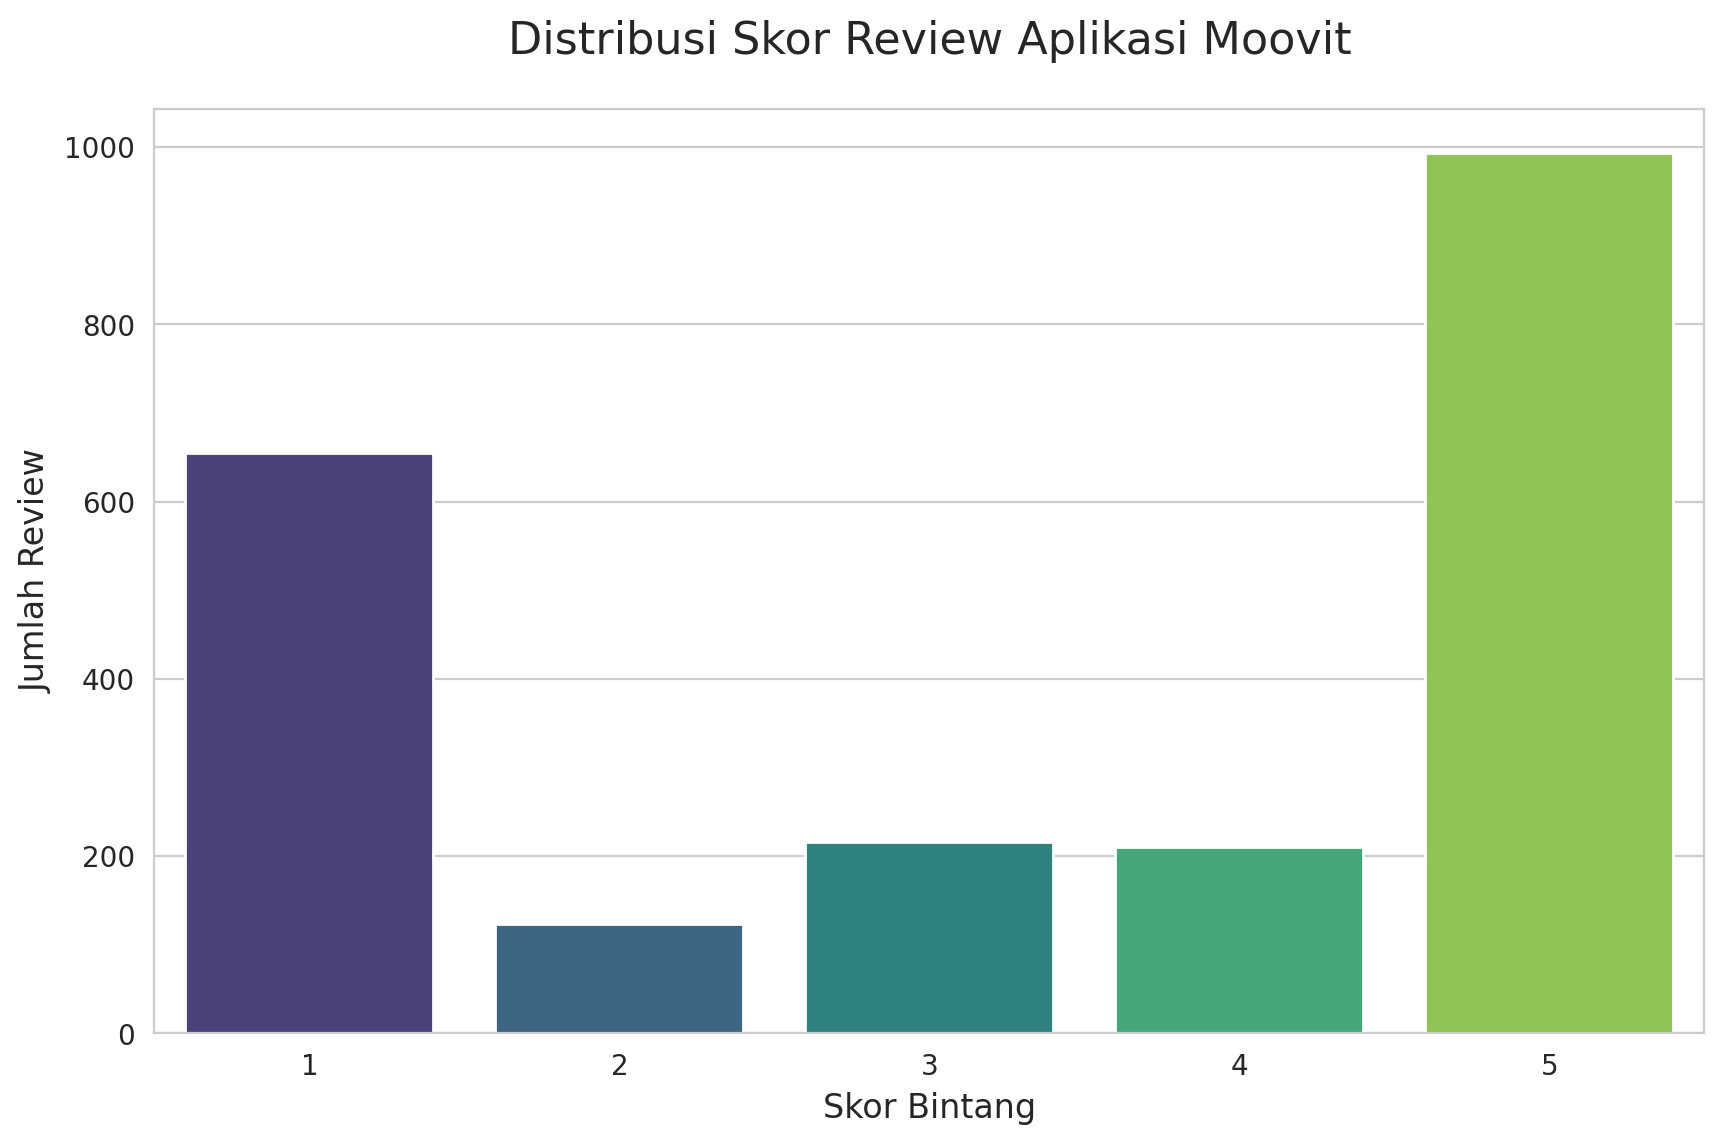

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='score', palette='viridis', order=[1, 2, 3, 4, 5])
plt.title('Distribusi Skor Review Aplikasi Moovit', fontsize=16, pad=20)
plt.xlabel('Skor Bintang', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.show()

--- Jumlah Review per Tahun ---
year
2014     59
2015     32
2016     14
2017     89
2018    224
2019    288
2020    231
2021    162
2022    298
2023    310
2024    299
2025    192
Name: count, dtype: int64


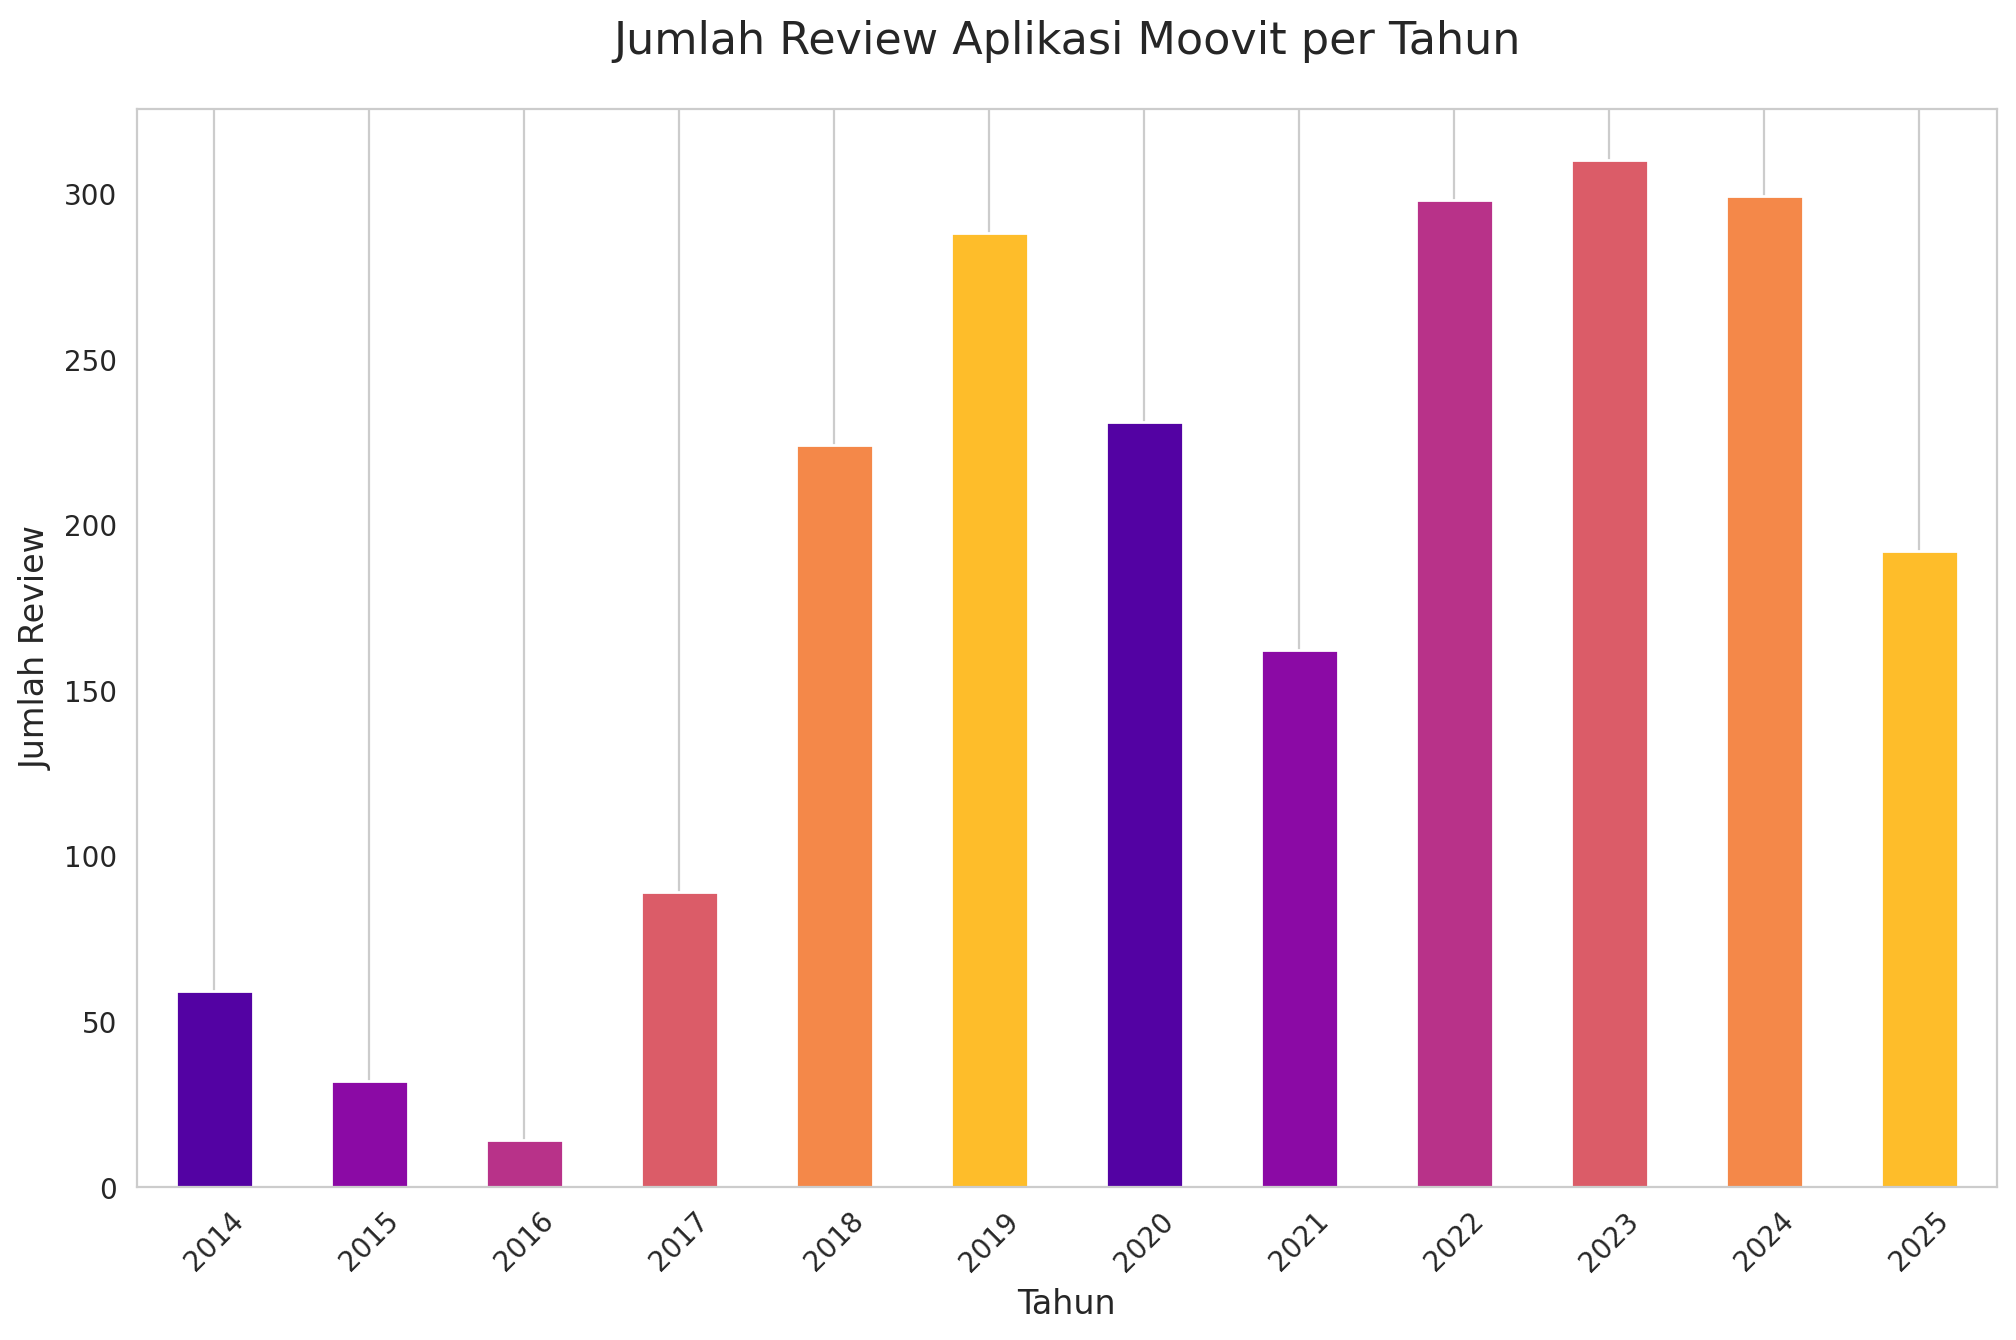

In [4]:
# Ekstrak tahun dari kolom 'at'
df['year'] = df['at'].dt.year

# Hitung jumlah review per tahun
reviews_per_year = df['year'].value_counts().sort_index()

print("--- Jumlah Review per Tahun ---")
print(reviews_per_year)

# Visualisasi
plt.figure(figsize=(12, 7))
reviews_per_year.plot(kind='bar', color=sns.color_palette("plasma"))
plt.title('Jumlah Review Aplikasi Moovit per Tahun', fontsize=16, pad=20)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

/tmp/ipython-input-395171035.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x='score', y='review_length', palette='magma')


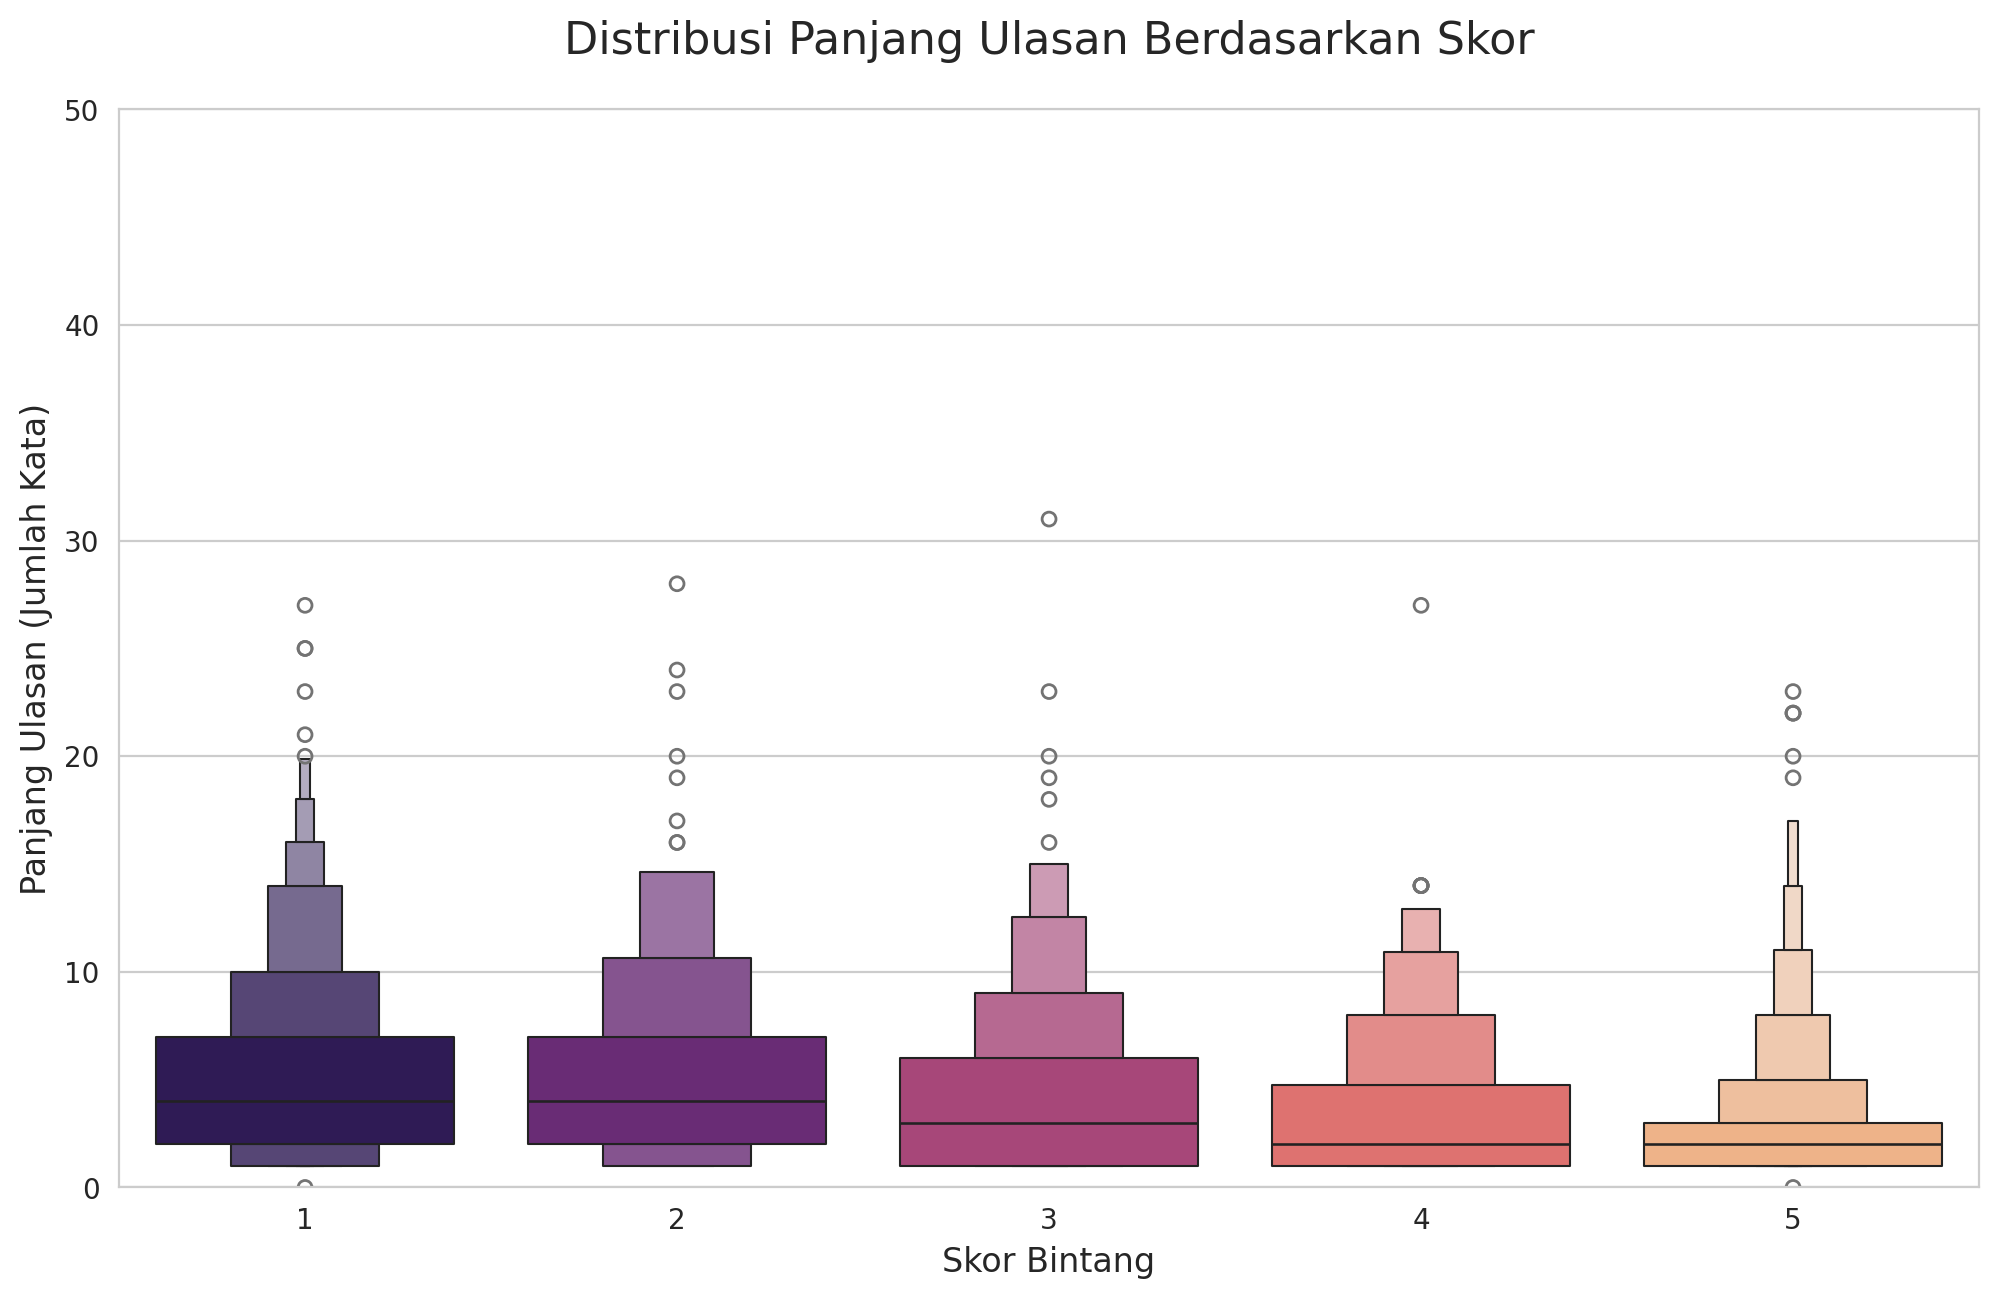


--- Statistik Panjang Ulasan Berdasarkan Skor ---
       count      mean       std  min  25%  50%   75%   max
score                                                      
1      655.0  4.928244  4.353920  0.0  2.0  4.0  7.00  27.0
2      124.0  5.701613  5.075014  1.0  2.0  4.0  7.00  28.0
3      216.0  4.509259  4.526913  1.0  1.0  3.0  6.00  31.0
4      210.0  3.638095  4.961331  1.0  1.0  2.0  4.75  52.0
5      993.0  2.790534  3.009131  0.0  1.0  2.0  3.00  23.0


In [5]:
# Hitung panjang ulasan (jumlah kata) pada teks yang sudah bersih
df['review_length'] = df['final_content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 7))
sns.boxenplot(data=df, x='score', y='review_length', palette='magma')
plt.title('Distribusi Panjang Ulasan Berdasarkan Skor', fontsize=16, pad=20)
plt.xlabel('Skor Bintang', fontsize=12)
plt.ylabel('Panjang Ulasan (Jumlah Kata)', fontsize=12)
plt.ylim(0, 50) # Batasi sumbu y agar lebih mudah dibaca
plt.show()

# Tampilkan statistik deskriptif
print("\n--- Statistik Panjang Ulasan Berdasarkan Skor ---")
print(df.groupby('score')['review_length'].describe())

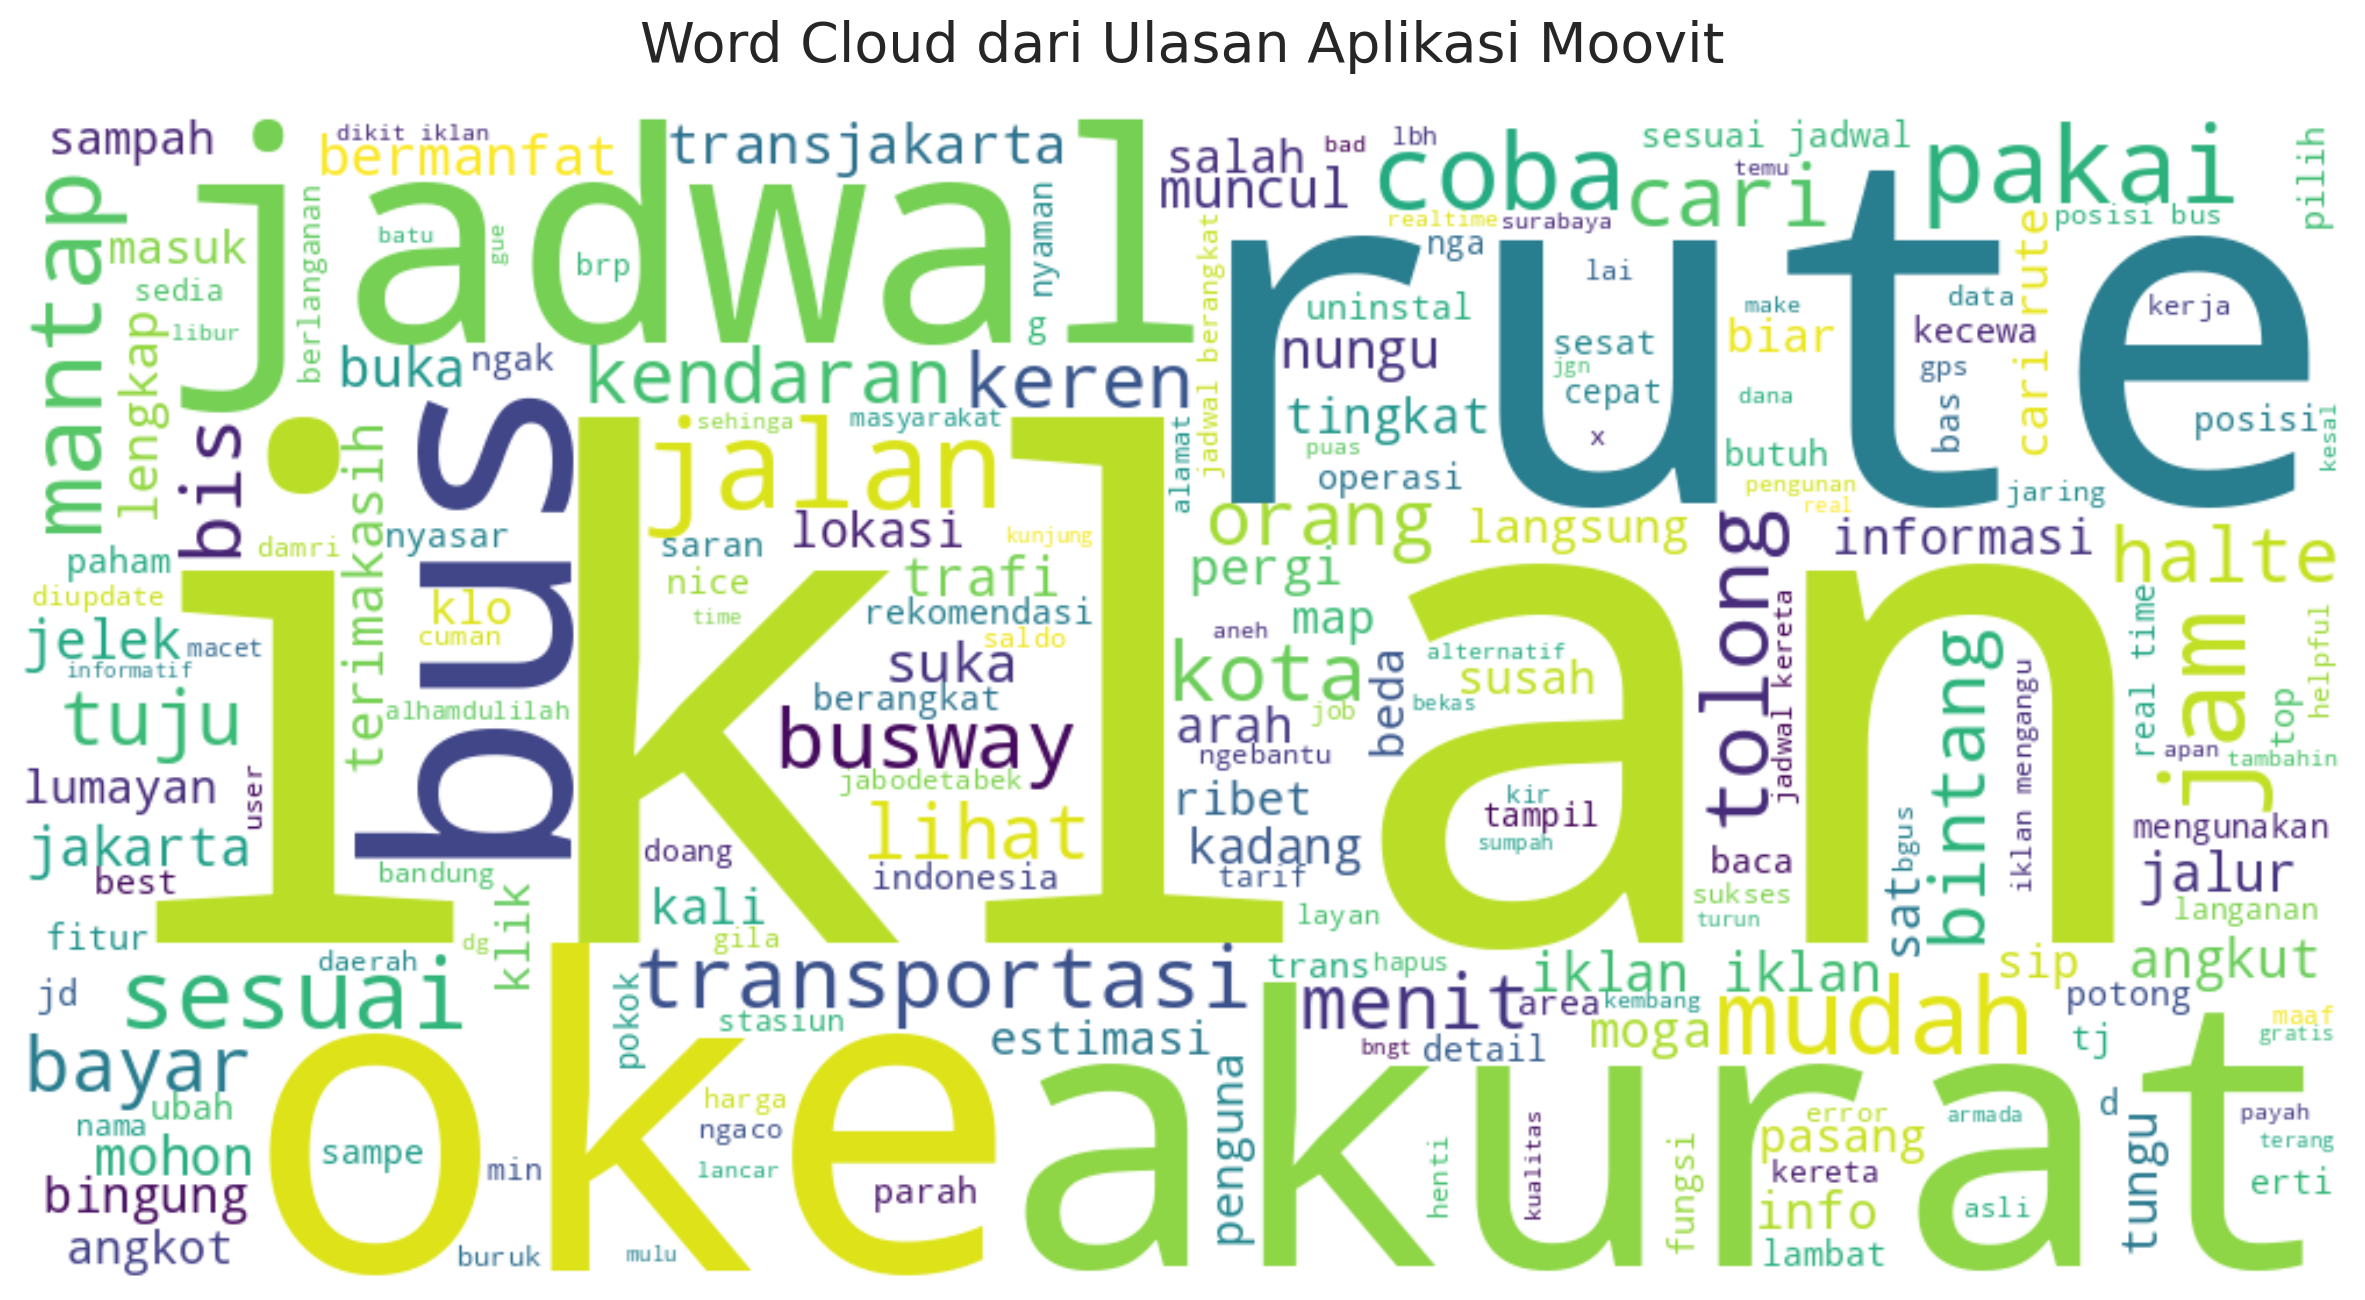

In [6]:
# Gabungkan semua teks bersih menjadi satu string besar
all_text = ' '.join(df['final_content'])

# Buat objek WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(all_text)

# Tampilkan gambar
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Ulasan Aplikasi Moovit', fontsize=20, pad=20)
plt.show()

## Tugas 2: Analisa BoW (Bag of Words)
Bag of Words adalah cara untuk merepresentasikan data teks sebagai data numerik. Kita akan mengubah ulasan yang sudah bersih menjadi matriks frekuensi kata menggunakan `CountVectorizer`.

In [7]:
# Inisialisasi CountVectorizer
# max_features=1000 berarti kita hanya akan mengambil 1000 kata dengan frekuensi tertinggi
bow_vectorizer = CountVectorizer(max_features=1000)

# Terapkan BoW pada kolom 'final_content'
bow_matrix = bow_vectorizer.fit_transform(df['final_content'])

# Tampilkan bentuk matriks yang dihasilkan (jumlah review, jumlah kata unik)
print("Bentuk Matriks BoW:", bow_matrix.shape)

# Buat DataFrame dari matriks BoW untuk melihat hasilnya
# bow_vectorizer.get_feature_names_out() digunakan untuk mendapatkan nama kolom (kata-kata unik)
df_bow = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

print("\n--- Contoh Hasil Bag of Words (5 baris pertama, 10 kolom pertama) ---")
print(df_bow.iloc[:5, :10])

# Tampilkan beberapa kata yang masuk dalam vocabulary
print("\n--- Contoh Kata dalam Kosakata (Vocabulary) ---")
print(list(bow_vectorizer.vocabulary_.keys())[:20])

Bentuk Matriks BoW: (2198, 948)

--- Contoh Hasil Bag of Words (5 baris pertama, 10 kolom pertama) ---
   akses  aktif  aktivitas  akun  akurasi  akurat  al  alah  alam  alamat
0      0      0          0     0        0       1   0     0     0       0
1      0      0          0     0        0       0   0     0     0       0
2      0      0          0     0        0       1   0     0     0       0
3      0      0          0     0        0       0   0     0     0       0
4      0      0          0     0        0       0   0     0     0       0

--- Contoh Kata dalam Kosakata (Vocabulary) ---
['akurat', 'berangkat', 'sesuai', 'nyasar', 'orang', 'halte', 'foto', 'biar', 'iklan', 'tulis', 'muncul', 'bintang', 'ksh', 'rute', 'pasang', 'lu', 'ko', 'ribet', 'tolol', 'salah']


## Tugas 3: Analisa Regex untuk Insight Positif & Negatif
Di sini, kita akan menggunakan Regular Expressions (Regex) untuk mencari kata kunci tertentu dalam ulasan asli dan mengklasifikasikannya secara sederhana sebagai positif atau negatif.

In [8]:
# Definisikan kata kunci. Kita ambil dari kata-kata yang sudah di-stem dan umum.
# Anda bisa memperluas daftar ini.
positive_keywords = [
    'bagus', 'baik', 'oke', 'sip', 'mantap', 'keren', 'puas', 'suka',
    'sangat suka', 'juara', 'terbaik', 'luar biasa', 'istimewa', 'mantul',
    'rekomendasi', 'rekomended', 'paham', 'mengerti', 'salut', 'jempol',
    'the best', 'sempurna', 'tanpa cela', 'paten', 'jempolan',
    'membantu', 'sangat membantu', 'terbantu', 'berguna', 'bermanfaat',
    'memudahkan', 'mudah', 'gampang', 'gampang banget', 'mudah banget',
    'simpel', 'praktis', 'efisien', 'fungsional', 'lengkap',
    'fitur lengkap', 'sangat lengkap', 'ngebantu', 'ngebantu banget',
    'andal', 'diandalkan', 'user friendly', 'intuitif', 'tampilan bagus',
    'akurat', 'tepat', 'sesuai', 'real time', 'presisi', 'cepat',
    'lancar', 'nggak lag', 'tidak lambat', 'ringan', 'enteng', 'nggak berat',
    'tepat waktu', 'on time', 'sesuai jadwal', 'nggak ngaret', 'nggak telat',
    'berhasil', 'sukses', 'bisa', 'selamat', 'terselamatkan',
    'good', 'nice', 'great', 'cool', 'ok', 'love', 'best', 'thanks',
    'thank you', 'very good', 'helpful', 'amazing', 'awesome',
    'terima kasih', 'makasih', 'terimakasih', 'makasih banyak', 'terima kasih banyak'
]
negative_keywords = [
    'iklan', 'banyak iklan', 'iklan terus', 'iklan melulu', 'iklan mulu',
    'ganggu iklan', 'iklannya', 'kebanyakan iklan', 'ads',
    'error', 'eror', 'bug', 'ngebug', 'crash', 'force close', 'berhenti',
    'terhenti', 'keluar sendiri', 'mental', 'mental-mentalan', 'sering mental',
    'nge-freeze', 'ngefreeze', 'blank', 'layar putih', 'tidak merespon', 'macet',
    'lambat', 'lemot', 'lama', 'loading lama', 'berat', 'lemot banget',
    'boros baterai', 'boros kuota', 'makan memori',
    'tidak akurat', 'ga akurat', 'gak akurat', 'kurang akurat', 'salah',
    'tidak sesuai', 'ga sesuai', 'beda', 'nyasar', 'salah rute', 'ngawur',
    'salah jadwal', 'bohong', 'ngaco', 'gajelas', 'ga jelas', 'info salah',
    'estimasi salah', 'ngaret', 'telat', 'tidak update', 'ketinggalan',
    'gagal', 'tidak bisa', 'gabisa', 'gak bisa', 'ga bisa', 'susah',
    'sulit', 'ribet', 'rumit', 'bingung', 'pusing', 'masalah', 'kendala',
    'tidak berfungsi', 'tidak jalan', 'ga bisa login', 'gabisa login',
    'tidak bisa daftar', 'verifikasi gagal', 'kode ga masuk', 'otp ga masuk',
    'nggak bisa dibuka', 'tidak bisa dibuka', 'susah banget',
    'jelek', 'buruk', 'parah', 'payah', 'kecewa', 'sampah', 'tolol', 'bodo',
    'menyusahkan', 'mengganggu', 'terganggu', 'uninstal', 'hapus aplikasi',
    'hancur', 'ancur', 'parah banget', 'ampas', 'bintang 1', 'kasih bintang 1',
    'mendingan hapus', 'ga guna', 'tidak berguna', 'ga recomended',
    'tidak direkomendasikan',
    'bayar', 'berbayar', 'mahal', 'uang', 'potong', 'kena potong',
    'tiba-tiba bayar', 'harus bayar', 'kenapa jadi bayar', 'paksa', 'dipaksa'
]

# Buat pola regex. Tanda '|' berarti 'ATAU'.
# re.IGNORECASE agar tidak membedakan huruf besar/kecil.
positive_pattern = re.compile('|'.join(positive_keywords), re.IGNORECASE)
negative_pattern = re.compile('|'.join(negative_keywords), re.IGNORECASE)

# Fungsi untuk menandai ulasan
# Kita gunakan ulasan asli ('content') agar konteksnya lebih kaya
def find_sentiment_keywords(review):
    review = str(review)
    # Cari kata kunci positif
    has_positive = 1 if positive_pattern.search(review) else 0
    # Cari kata kunci negatif
    has_negative = 1 if negative_pattern.search(review) else 0
    return pd.Series([has_positive, has_negative])

# Terapkan fungsi pada DataFrame
df[['has_positive_keyword', 'has_negative_keyword']] = df['content'].apply(find_sentiment_keywords)

print("Penandaan kata kunci selesai.")
df[['content', 'has_positive_keyword', 'has_negative_keyword']].sample(10)

Penandaan kata kunci selesai.


,content,has_positive_keyword,has_negative_keyword
1522,Min Usulan Saya Disertai Dengan Nomor Lambungnya Contoh KAJ:KAJ 10xxxx TSW:TSW 18xxx,0,0
252,Pelayanan untuk Customer atau Pelanggan adalah *****BAIK*****,1,0
1142,pas mau cari rute malah error,0,1
952,Aplikasi sampah... Jadwal ama asli nya gak sesuai...,1,1
1639,Sangat membantu dan cepat.,1,0
576,"suka keluar² sendiri. dah gitu ada rute bus nya yg ngaco, udah saya kasih saran masukan belom diperbaikin juga tuh sampe sekarang. iklan doang digedein 👎",1,1
1476,Lumayan bagus,1,0
830,"Sangat membantu saat digunakan di vigo spanyol, Tapi saya juga membutuhkan koneksi dengan taxy melalui aplikasi ini",1,0
0,Akurat dan sangat diperlukan,1,0
2458,Ini sangat membantu saya yg kurang tau info unk transportasi,1,0


Jumlah ulasan dengan kata kunci positif: 1418
Jumlah ulasan dengan kata kunci negatif: 763
Jumlah ulasan yang mengandung keduanya: 408
Jumlah ulasan tanpa kata kunci terdefinisi: 425


/tmp/ipython-input-2656022502.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts, x='Sentimen', y='Jumlah', palette='pastel')


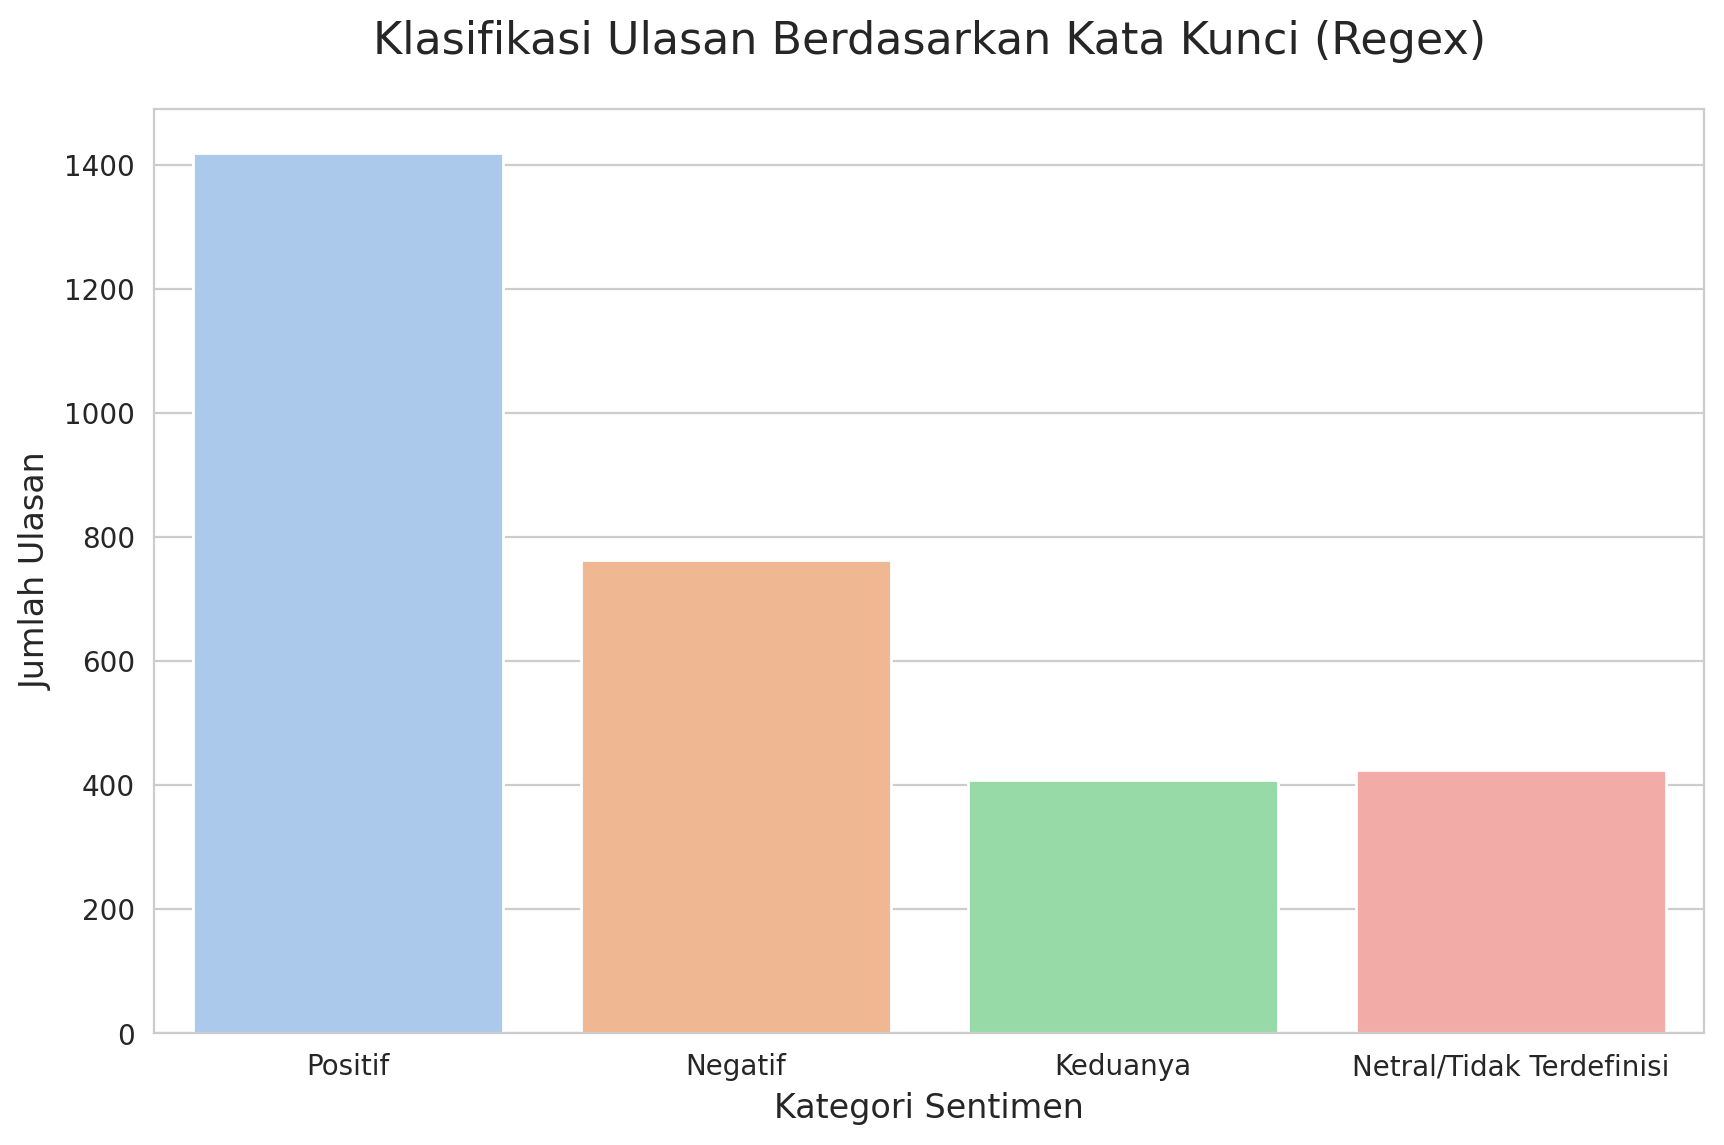


--- Contoh Ulasan yang Mengandung Kata Kunci Positif & Negatif ---
                                                                                                                                                                                                    content
1   apk gajelas, waktu keberangkatan jak di moovit ga sesuai malah bikin nyasar orang trs halte juga ga jelas org mah ada fotonya biar jelas & tau😡😡😡. ini apk bnr' ga bisa di pk & banyak iklan, pdhl a...
2                                                                                                                                                     ga jelas, ga akurat sama sekali sama rute jaklingko !
10                                                                                                                         makin kesini makin banyak iklan, bukannya membantu malah bikin ribet gara2 iklan
18                                                                                                                  

In [9]:
# Hitung jumlah ulasan untuk setiap kategori
positive_reviews = df['has_positive_keyword'].sum()
negative_reviews = df['has_negative_keyword'].sum()
both_keywords = df[(df['has_positive_keyword'] == 1) & (df['has_negative_keyword'] == 1)].shape[0]
no_keywords = df[(df['has_positive_keyword'] == 0) & (df['has_negative_keyword'] == 0)].shape[0]

print(f"Jumlah ulasan dengan kata kunci positif: {positive_reviews}")
print(f"Jumlah ulasan dengan kata kunci negatif: {negative_reviews}")
print(f"Jumlah ulasan yang mengandung keduanya: {both_keywords}")
print(f"Jumlah ulasan tanpa kata kunci terdefinisi: {no_keywords}")

# Membuat DataFrame untuk visualisasi
sentiment_counts = pd.DataFrame({
    'Sentimen': ['Positif', 'Negatif', 'Keduanya', 'Netral/Tidak Terdefinisi'],
    'Jumlah': [positive_reviews, negative_reviews, both_keywords, no_keywords]
})

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_counts, x='Sentimen', y='Jumlah', palette='pastel')
plt.title('Klasifikasi Ulasan Berdasarkan Kata Kunci (Regex)', fontsize=16, pad=20)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.show()

# Tampilkan contoh ulasan yang mengandung kedua jenis kata kunci
print("\n--- Contoh Ulasan yang Mengandung Kata Kunci Positif & Negatif ---")
print(df[(df['has_positive_keyword'] == 1) & (df['has_negative_keyword'] == 1)][['content']].head())